# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [4]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    !pip install fairscale
    %cd BLIP

Running in Colab.
  Using cached transformers-4.15.0-py3-none-any.whl.metadata (59 kB)
  Using cached timm-0.4.12-py3-none-any.whl.metadata (30 kB)
  Using cached fairscale-0.4.4-py3-none-any.whl
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_

In [47]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    # img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
    file_id = "1mi56l7pug0DGqqUwkYL3kYuEQhWrqIfM"
    # file_id = "1Sd3wKMJ6LnB_ltNb3lKUKkweXNxnxaLF"
    img_url = f"https://drive.google.com/uc?export=download&id={file_id}"

    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

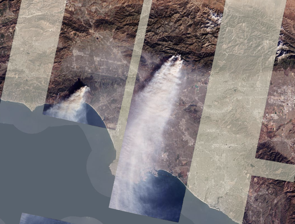

Image shape: torch.Size([1, 3, 480, 480])
Image Dtype: torch.float32
reshape position embedding from 196 to 900
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a large plume of smoke rising from the ground


In [50]:
from models.blip import blip_decoder

image_size = 480
image = load_demo_image(image_size=image_size, device=device)

print("Image shape:", image.shape)  # Should be [1, 3, 384, 384]
print("Image Dtype:", image.dtype)  # Should be torch.float32

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
# print(model)

model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=1, max_length=30, min_length=5)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
    print('caption: '+caption[0])